# Imports and paths

In [95]:
import os
import sys

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

import polars as pl
import pandas as pd
import numpy as np

In [96]:
from config import TRAIN_PARQUET_PATH, TEST_PARQUET_PATH, PRODUCTS_PARQUET_PATH, USERS_DATA_PATH, PRODUCTS_PARQUET_PATH_IMPUTED, ALL_PRODS_TRAINTEST_PATH
from src.data.loaders import PolarsLoader
from src.utils import filter_polars

## Train and test processing

In [97]:
loader = PolarsLoader(sampling=True, file_type='parquet')
train = loader.load_data(path=TRAIN_PARQUET_PATH)
test = loader.load_data(path=TEST_PARQUET_PATH)
train.head()

session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype
u32,date,datetime[μs],u8,u32,u8,u16,u8,u8
64,2024-06-06,2024-06-06 16:43:17.389,0,null,29,14327,1,24
117,2024-06-08,2024-06-08 15:11:02.782,0,null,57,38422,1,24
117,2024-06-08,2024-06-08 15:11:44.797,0,null,57,19763,1,24
579,2024-06-05,2024-06-05 19:24:48.397,0,null,29,30253,1,24
1220,2024-06-04,2024-06-04 08:21:13.476,0,480729,25,1592,1,24


In [98]:
print("*"*50)
print("TRAIN DATA:")
print("*"*50)
print("Unique session IDs")
print(train['session_id'].n_unique())

print("\nNumber of interacted products")
print(train['partnumber'].n_unique())

print("\nDate range:")
print(train['date'].min())
print(train['date'].max()) #----> Extraer entonces solo: NUMERO DIA, NUMERO DIA DE LA SEMANA, NOMBRE DIA DE LA SEMANA, NUMERO HORA, MAÑANA/TARDE/NOCHE

print("\n","*"*50)
print("TEST DATA:")
print("*"*50)
print("Unique session IDs")
print(test['session_id'].n_unique())

print("\nNumber of interacted products")
print(test['partnumber'].n_unique())

print("\nDate range:")
print(test['date'].min())
print(test['date'].max())

**************************************************
TRAIN DATA:
**************************************************
Unique session IDs
95364

Number of interacted products
26380

Date range:
2024-06-01
2024-06-15

 **************************************************
TEST DATA:
**************************************************
Unique session IDs
7349

Number of interacted products
9253

Date range:
2024-06-15
2024-06-16


I saved all products in train/test data to drop the "not present" in products data

In [99]:
# # Save products in train/test to reduce product dataset
# train_prods = train.select('partnumber').unique()
# train_prods = list(train_prods.to_series())

# test_prods = test.select('partnumber').unique()
# test_prods = list(test_prods.to_series())

# print("Total number of products in train + test datasets: ", len(set(train_prods + test_prods)))

# all_prods = list(set(train_prods + test_prods))

# # Save to JSON
# with open(ALL_PRODS_TRAINTEST_PATH, 'w') as f:
#     json.dump(all_prods, f)

### NA imputation

In [100]:
def impute_train_test(df):
    
    return df.with_columns([pl.col("user_id").fill_null(-1).cast(pl.Int32),
                        pl.col("pagetype").fill_null(pl.col("pagetype").mode()),
                        ])

train = impute_train_test(train)
test = impute_train_test(test)

In [101]:
# # Is each session from a single user? SI
# train.drop_nulls()\
#     .group_by('session_id')\
#         .agg(pl.col('user_id').n_unique())\
#             .sort('user_id', descending=True)

In [102]:
# Some session with several interactions
train.drop_nulls()\
    .group_by('session_id')\
        .agg(pl.col('user_id').count())\
            .sort('user_id', descending=True)\
                .filter(pl.col('user_id') >= 30)

session_id,user_id
u32,u32
3745893,6480
205622,2022
2247260,1619
2656537,1132
3058982,1115
…,…
17947,30
3033819,30
2487984,30


In [103]:
# 2 FEATURES IMPORTANTES A CREAR
# 1. Cuanto duro cada interaccion
# 2. Si es la primera interaccion con el producto o que numero es

def feature_engineering_no_candidate_dependent(df: pl.DataFrame) -> pl.DataFrame:

    # Cleaning and sorting
    df_ = (df.clone()
           .drop("date")
           .sort("timestamp_local")
    )

    df_ = df_.with_columns([
        # Calculate the difference in timestamps within each session
        (pl.col("timestamp_local").diff().over("session_id").cast(pl.Float32) / 1_000_000).alias("seconds_since_last_interaction"),
        # Total session duration in seconds
        ((pl.col("timestamp_local").max() - pl.col("timestamp_local").min()).over("session_id").cast(pl.Float32) / 1_000_000).alias("total_session_time"),
    ]).fill_null(strategy="zero")

    df_ = df_.with_columns([
                pl.col("seconds_since_last_interaction").shift(-1).over("session_id").alias("interaction_length"),
    ]).fill_null(strategy="zero")

    # Date features
    df_ = df_.with_columns([
        # Extracting day number
        pl.col("timestamp_local").dt.day().alias("day_number"),
        
        # Extracting weekday number
        pl.col("timestamp_local").dt.weekday().alias("weekday_number"),
        
        # Extracting weekday name
        pl.col("timestamp_local").dt.strftime("%A").alias("weekday_name").cast(pl.Categorical),
        
        # Extracting hour
        pl.col("timestamp_local").dt.hour().alias("hour")
    ])

    def get_day_frame(hour: int) -> int:
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        elif 18 <= hour < 24:
            return 'Night'
        else:
            return 'Late Night'
        
    df_ = df_.with_columns([
                    pl.col("hour").map_elements(get_day_frame, return_dtype=pl.String).alias("day_frame").cast(pl.Categorical)
                ])

    return df_

train_eng = feature_engineering_no_candidate_dependent(train)
test_eng = feature_engineering_no_candidate_dependent(test)

In [104]:
#1 session example
train_eng.filter(pl.col('session_id') == 3033819).tail()

session_id,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype,seconds_since_last_interaction,total_session_time,interaction_length,day_number,weekday_number,weekday_name,hour,day_frame
u32,datetime[μs],u8,i32,u8,u16,u8,u8,f32,f32,f32,i8,i8,cat,i8,cat
3033819,2024-06-01 17:51:54.800,0,-1,57,2549,1,24,54.492001,1335.773071,4.722,1,6,"""Saturday""",17,"""Afternoon"""
3033819,2024-06-01 17:51:59.522,0,-1,57,18361,1,24,4.722,1335.773071,7.419,1,6,"""Saturday""",17,"""Afternoon"""
3033819,2024-06-01 17:52:06.941,0,-1,57,15115,1,24,7.419,1335.773071,18.917999,1,6,"""Saturday""",17,"""Afternoon"""
3033819,2024-06-01 17:52:25.859,0,-1,57,18772,1,24,18.917999,1335.773071,26.851999,1,6,"""Saturday""",17,"""Afternoon"""
3033819,2024-06-01 17:52:52.711,0,-1,57,35865,1,24,26.851999,1335.773071,0.0,1,6,"""Saturday""",17,"""Afternoon"""


## Selecting candidates
This is the plan...

- Global Popular Products:
    - Select 50–100 most popular products globally.
    - Use these as candidates for all sessions.

- Country-Specific Popular Products:
    - For each session, identify the user's country.
    - Select the 50–100 most popular products for that country.

- Similar Products:
    For every session, regardless of user history:
    - Select ~20 products most similar to the product(s) in the interaction.
    - User History Products:

For users with history in the Train dataset:
Include all products they interacted with but did not add to the cart.

## Adding candidates to test
- I have to add them at the end of session (max timestamp) for the feature to "count interaction"
- I have to drop duplicate addition because that "count" would increase

### 1. Take Top popular products from train
I create a dataframe with top 500 to later select how many to feed to test

In [105]:
cart_counts = (train_eng
 .group_by('partnumber')
 .agg(pl.col('add_to_cart').count())
 .sort('add_to_cart', descending=True)
 .limit(500)
)

In [106]:
cart_counts

partnumber,add_to_cart
u16,u32
1181,3234
41749,3221
32700,1313
33777,1177
11031,903
…,…
1552,279
43112,279
36192,278


Total products:  500


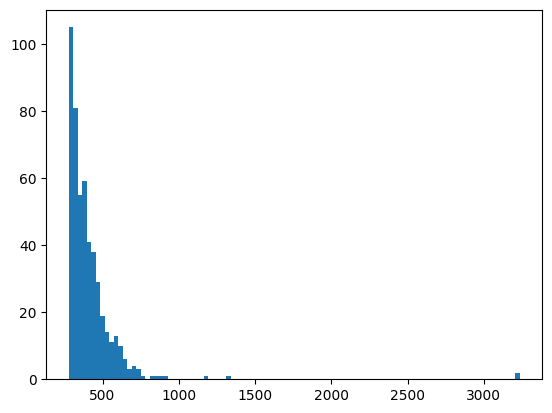

In [107]:
import matplotlib.pyplot as plt
cart_additions = 200
selected_plot = cart_counts.filter(pl.col('add_to_cart')> cart_additions)
print("Total products: ", cart_counts['partnumber'].n_unique())
plt.hist(cart_counts.filter(pl.col('add_to_cart')> cart_additions)['add_to_cart'], bins=100);

### 2. Add to test

In [108]:
# Some session with several interactions
test_eng.drop_nulls()\
    .group_by('session_id')\
        .agg(pl.col('user_id').count())\
            .sort('user_id', descending=True)\
                .filter(pl.col('user_id') >= 5)

session_id,user_id
u32,u32
2999411,10
4422250,10
3712870,10
1248317,10
671670,10
…,…
1324294,5
509208,5
2703885,5


In [109]:
TOPN_GLOBAL = 10
top_global_prods = cart_counts['partnumber'].head(TOPN_GLOBAL).to_list()

In [110]:
def add_candidates_to_test(test_df: pl.DataFrame, candidate_products: list) -> pl.DataFrame:
    """Adds candidate products as new rows for each session in test data"""
    test_session_ids = test_df["session_id"].unique()

    # Create a dataframe with all the candidate products for each session
    candidates = [
        {"session_id": sid, "partnumber": pn}
        for sid in test_session_ids 
        for pn in candidate_products
    ]
    candidates_df = pl.DataFrame(candidates).with_columns([
        pl.col("session_id").cast(pl.UInt32),
        pl.col("partnumber").cast(pl.UInt16)
    ])
    
    # Add the candidate products to the test data
    test_extended = pl.concat([test_df, candidates_df], how="diagonal").unique()

    # Fill missing values with generated
    # test_extended = test_extended.group_by("session_id").map_groups(
    #             lambda group: group.sort("timestamp_local", descending=True)
    #             .fill_null(strategy="backward"))

    #Fill missing values with generated: Faster version
    backfilled_cols = ['timestamp_local',
                        'user_id',
                        'country',
                        'device_type',
                        'pagetype',
                        'total_session_time',
                        'day_number',
                        'weekday_number',
                        'weekday_name',
                        'hour',
                        'day_frame']
    
    statsfilled_cols = ['seconds_since_last_interaction',
                        'interaction_length']
    
    test_extended = (test_extended
                    .sort(["session_id", "timestamp_local"], descending=[False, True])
                    .with_columns([
                        pl.col(col).fill_null(strategy='backward').over("session_id") 
                        for col in backfilled_cols
                    ])
                    .with_columns([
                        pl.col(col).fill_null(strategy='mean').over("session_id") 
                        for col in statsfilled_cols
                    ])
                )

    return test_extended

In [111]:
test_extended = add_candidates_to_test(test_eng, top_global_prods)

/tmp/ipykernel_72827/80947312.py:17: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  test_extended = pl.concat([test_df, candidates_df], how="diagonal").unique()


### 3. Create extra features depending on candidates

In [112]:
def feature_engineering_candidate_dependent(df: pl.DataFrame) -> pl.DataFrame:
    
    df = df.with_columns([
        # Assign a cumulative count for each partnumber within a session
        pl.col("partnumber").cum_count().over(["session_id", "partnumber"]).alias("product_interaction_count")
    ]).fill_null(strategy="zero")

    return df

In [113]:
train_eng = feature_engineering_candidate_dependent(train_eng)
test_extended = feature_engineering_candidate_dependent(test_extended)

In [114]:
train_eng.head()

session_id,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype,seconds_since_last_interaction,total_session_time,interaction_length,day_number,weekday_number,weekday_name,hour,day_frame,product_interaction_count
u32,datetime[μs],u8,i32,u8,u16,u8,u8,f32,f32,f32,i8,i8,cat,i8,cat,u32
3430915,2024-06-01 02:00:00.399,0,-1,57,11490,1,24,0.0,889.921997,40.452,1,6,"""Saturday""",2,"""Late Night""",1
3859571,2024-06-01 02:00:00.829,0,-1,34,16688,1,24,0.0,1890.589966,48.697998,1,6,"""Saturday""",2,"""Late Night""",1
2706260,2024-06-01 02:00:01.985,0,-1,34,6807,1,24,0.0,129.283997,9.211,1,6,"""Saturday""",2,"""Late Night""",1
3686634,2024-06-01 02:00:03.828,0,-1,34,14566,1,24,0.0,1686.774048,11.237,1,6,"""Saturday""",2,"""Late Night""",1
4175670,2024-06-01 02:00:09.282,0,-1,57,22950,1,24,0.0,253.373993,1.373,1,6,"""Saturday""",2,"""Late Night""",1


In [115]:
test_extended.head()

session_id,timestamp_local,user_id,country,partnumber,device_type,pagetype,seconds_since_last_interaction,total_session_time,interaction_length,day_number,weekday_number,weekday_name,hour,day_frame,product_interaction_count
u32,datetime[μs],i32,u8,u16,u8,u8,f32,f32,f32,i8,i8,cat,i8,cat,u32
746,2024-06-15 18:39:15.605,-1,57,23647,1,24,21.173571,148.215012,21.173571,15,6,"""Saturday""",18,"""Night""",1
746,2024-06-15 18:39:15.605,-1,57,27789,1,24,21.173571,148.215012,21.173571,15,6,"""Saturday""",18,"""Night""",1
746,2024-06-15 18:39:15.605,-1,57,33777,1,24,21.173571,148.215012,21.173571,15,6,"""Saturday""",18,"""Night""",1
746,2024-06-15 18:39:15.605,-1,57,11031,1,24,21.173571,148.215012,21.173571,15,6,"""Saturday""",18,"""Night""",1
746,2024-06-15 18:39:15.605,-1,57,41749,1,24,21.173571,148.215012,21.173571,15,6,"""Saturday""",18,"""Night""",1
